In [1]:
import sys
# Assuming you are currently in the 'backtester' directory, 
# you need to go up one level to the 'project_folder' and then into 'TestFolder'
sys.path.append('../') 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Callable

# Now you can import Strat1
from Alphas.strat1 import Strat1
from Alphas.strat2 import Strat2
from Alphas.stratwithparam import StratWithParam
from quantutils.backtester_utils import calc_stats
from Alphas.mainalpha import Alpha
from itertools import product, combinations, permutations
from Alphas.alphaminer import AlphaMiner, generate_param_combinations_and_multi_index
sns.set()

sns.set_style('darkgrid')
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(22)
contract_size = pd.Series([25, 1, 5, 3, 10])
T = 5000
df_ret = pd.DataFrame(np.random.normal(loc=0.001, scale=0.02, size=(T, 5)))
df_ret.index = pd.date_range('2010-01-01', periods=T)
df_ret = df_ret *np.array([1.0, 1.5, 3.0, 0.2, 2.0]) + 1
df_ret.iloc[0] = [1, 10, 20, 8, 30]
df_ret
df_price =  (df_ret).cumprod()
### df_dict
attributes = ['high', 'close', 'low', 'max', 'trend']
df_dict = {}

for attribute in attributes:
    window = np.random.randint(5, 101)
    df_signal = (df_price.pct_change(window).shift(-window+1) + np.random.normal(scale=0.5, size=df_ret.shape)).shift().ffill().bfill() * 100
    df_signal = df_signal.rolling(20).mean()

    df_signal = df_signal/df_signal.std()
    df_dict[attribute] = df_signal
    
df_dict['price'] = df_price
df_dict['low'] = df_dict['low'].drop(0 ,axis=1)
contract_size = {k : np.random.randint(1, 20) for k in range(df_ret.shape[1])}


In [3]:

strat1 = Strat1(df_dict, '2010-01-01', '2013-01-01', 1_000_000, contract_size)
strat1.run_backtest()
strat2 = Strat2(df_dict, '2010-01-01', '2013-01-01', 1_000_000, contract_size)
strat2.run_backtest()
start = '2010-01-01'
end = '2013-01-01'
shift_signal = 2
pre_compute_params = {'attribute': 'high'}
post_compute_params = {'rolling_window': 10, 'mult': 0.02}
strat3 = StratWithParam(df_dict, start, end, 1_000_000, contract_size, shift_signal,
                        pre_compute_params, post_compute_params)

strat3.run_backtest()
strat3.df_pnl_nominal

,0,1,2,3,4
2010-02-04,35423.768295,-66491.274889,-67834.574080,31377.769435,308341.401530
2010-02-05,-5011.525203,54411.525227,448704.283924,3625.553291,-54401.964833
2010-02-06,198363.456989,-20675.601067,-131314.381247,24658.777326,-137840.630789
2010-02-07,45470.243967,22838.079958,-7962.202106,17265.875456,211170.398272
2010-02-08,77674.694669,-47627.639010,46728.230547,-13920.990410,79091.294709
...,...,...,...,...,...
2012-12-30,2081.193630,6.793345,-79796.379993,2107.554182,-1930.144028
2012-12-31,14162.354489,-11.472801,75429.691963,-1190.996616,5497.005794
2013-01-01,5263.526970,-22.398290,28858.230758,-532.562267,-7196.823444
2013-01-02,-856.132764,-1970.929716,44632.364526,431.450303,11536.784309


In [6]:
import time

    
pre_compute_params_mega = {'attribute': ['high', 'low', 'trend', 'max']}
post_compute_params_mega = {'rolling_window': np.random.randint(2, 50, 10), 'mult': [0.1, 0.2, 0.3, 0.4]}    
combinations, multiindex = generate_param_combinations_and_multi_index(pre_compute_params_mega, post_compute_params_mega)
start = '2010-01-01'
end = '2023-01-01'
strat_skeleton = StratWithParam(df_dict, start, end, 1_000_000, contract_size, 2)
alphaminer = AlphaMiner(strat_skeleton, pre_compute_params_mega, post_compute_params_mega)
# multiindex = generate_multiindex(pre_compute_params_mega, post_compute_params_mega)
(alphaminer.parameters_mining())


Number Of Combinations: 160
({'attribute': 'high'}, {'rolling_window': 8, 'mult': 0.1})
({'attribute': 'high'}, {'rolling_window': 8, 'mult': 0.2})
({'attribute': 'high'}, {'rolling_window': 8, 'mult': 0.3})
({'attribute': 'high'}, {'rolling_window': 8, 'mult': 0.4})
({'attribute': 'high'}, {'rolling_window': 32, 'mult': 0.1})
({'attribute': 'high'}, {'rolling_window': 32, 'mult': 0.2})
({'attribute': 'high'}, {'rolling_window': 32, 'mult': 0.3})
({'attribute': 'high'}, {'rolling_window': 32, 'mult': 0.4})
({'attribute': 'high'}, {'rolling_window': 38, 'mult': 0.1})
({'attribute': 'high'}, {'rolling_window': 38, 'mult': 0.2})
({'attribute': 'high'}, {'rolling_window': 38, 'mult': 0.3})
({'attribute': 'high'}, {'rolling_window': 38, 'mult': 0.4})
({'attribute': 'high'}, {'rolling_window': 15, 'mult': 0.1})
({'attribute': 'high'}, {'rolling_window': 15, 'mult': 0.2})
({'attribute': 'high'}, {'rolling_window': 15, 'mult': 0.3})
({'attribute': 'high'}, {'rolling_window': 15, 'mult': 0.4})


In [68]:
groupings = {'EM': [0, 1, 2, 6, 7], 'DM': [3]}
alpha1 = Strat1(df_dict, start, end, 1_000_000, contract_size, 2)
alpha1.pnl_decomposition(groupings, [0, 0.01, 0.001, 0.0001])
alpha1.run_robustness_tests(100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

df_weight

In [70]:
alpha1.df_robustness_stats.drop('Execution', axis=1)

Cross-Section                                                               \
       daily_ret daily_std   ann_ret   ann_std    sharpe average_dd    max_dd   
0       0.000313  0.004437  0.078987  0.070428  1.121528   0.018823  0.073260   
1       0.000316  0.004367  0.079695  0.069317  1.149716   0.022851  0.114836   
2       0.000183  0.004389  0.046052  0.069668  0.661018   0.045105  0.149503   
3       0.000120  0.004198  0.030321  0.066643  0.454973   0.094123  0.189126   
4       0.000320  0.004392  0.080721  0.069717  1.157835   0.021264  0.091487   
..           ...       ...       ...       ...       ...        ...       ...   
95      0.000298  0.004294  0.075193  0.068163  1.103140   0.024341  0.082948   
96      0.000050  0.004255  0.012569  0.067541  0.186096   0.044824  0.112410   
97      0.000192  0.004362  0.048454  0.069249  0.699700   0.035491  0.122911   
98      0.000266  0.004281  0.066967  0.067966  0.985309   0.023114  0.096900   
99      0.000140  0.004283  0.035234  0.067997  0.518166   0.036183  0.121044   

   Time-Series                      ...                                 \
     daily_ret daily_std   ann_ret  ...    sharpe average_dd    max_dd   
0    -0.000054  0.004621 -0.013514  ... -0.184222   0.096150  0.216157   
1     0.000020  0.004561  0.005112  ...  0.070599   0.098432  0.213453   
2    -0.000161  0.004553 -0.040613  ... -0.561870   0.177909  0.250651   
3     0.000087  0.004725  0.021859  ...  0.291427   0.065859  0.183013   
4     0.000062  0.004672  0.015524  ...  0.209335   0.077741  0.170698   
..         ...       ...       ...  ...       ...        ...       ...   
95   -0.000100  0.004663 -0.025081  ... -0.338846   0.079349  0.175994   
96   -0.000123  0.004635 -0.030903  ... -0.419961   0.074885  0.246441   
97    0.000044  0.004819  0.011118  ...  0.145316   0.081353  0.162605   
98   -0.000183  0.004558 -0.046179  ... -0.638269   0.124275  0.252058   
99    0.000060  0.004639  0.015123  ...  0.205358   0.060557  0.162857   

        Both                                                               
   daily_ret daily_std   ann_ret   ann_std    sharpe average_dd    max_dd  
0   0.000184  0.004438  0.046307  0.070450  0.657314   0.027309  0.102318  
1   0.000111  0.004354  0.028094  0.069116  0.406476   0.054066  0.173249  
2  -0.000149  0.004430 -0.037549  0.070330 -0.533901   0.073150  0.210090  
3   0.000124  0.004383  0.031159  0.069582  0.447805   0.036683  0.097493  
4  -0.000011  0.004323 -0.002725  0.068628 -0.039704   0.045533  0.108675  
..       ...       ...       ...       ...       ...        ...       ...  
95 -0.000050  0.004418 -0.012508  0.070138 -0.178327   0.054608  0.117027  
96  0.000046  0.004438  0.011579  0.070458  0.164337   0.060545  0.162987  
97  0.000117  0.004581  0.029541  0.072724  0.406199   0.032145  0.096323  
98  0.000257  0.004387  0.064849  0.069639  0.931219   0.017640  0.076820  
99 -0.000204  0.004394 -0.051455  0.069759 -0.737602   0.105971  0.305481  

[100 rows x 21 columns]

In [57]:
alpha1.df_stats_with_tc

,daily_ret,daily_std,ann_ret,ann_std,sharpe,average_dd,max_dd
0.0000,0.001102,0.004479,0.277600,0.071097,3.904525,0.004641,0.028235
0.0100,0.000654,0.004489,0.164730,0.071259,2.311709,0.008630,0.052122
0.0010,0.001057,0.004479,0.266313,0.071101,3.745577,0.004895,0.028630
0.0001,0.001097,0.004479,0.276471,0.071097,3.888636,0.004665,0.028275


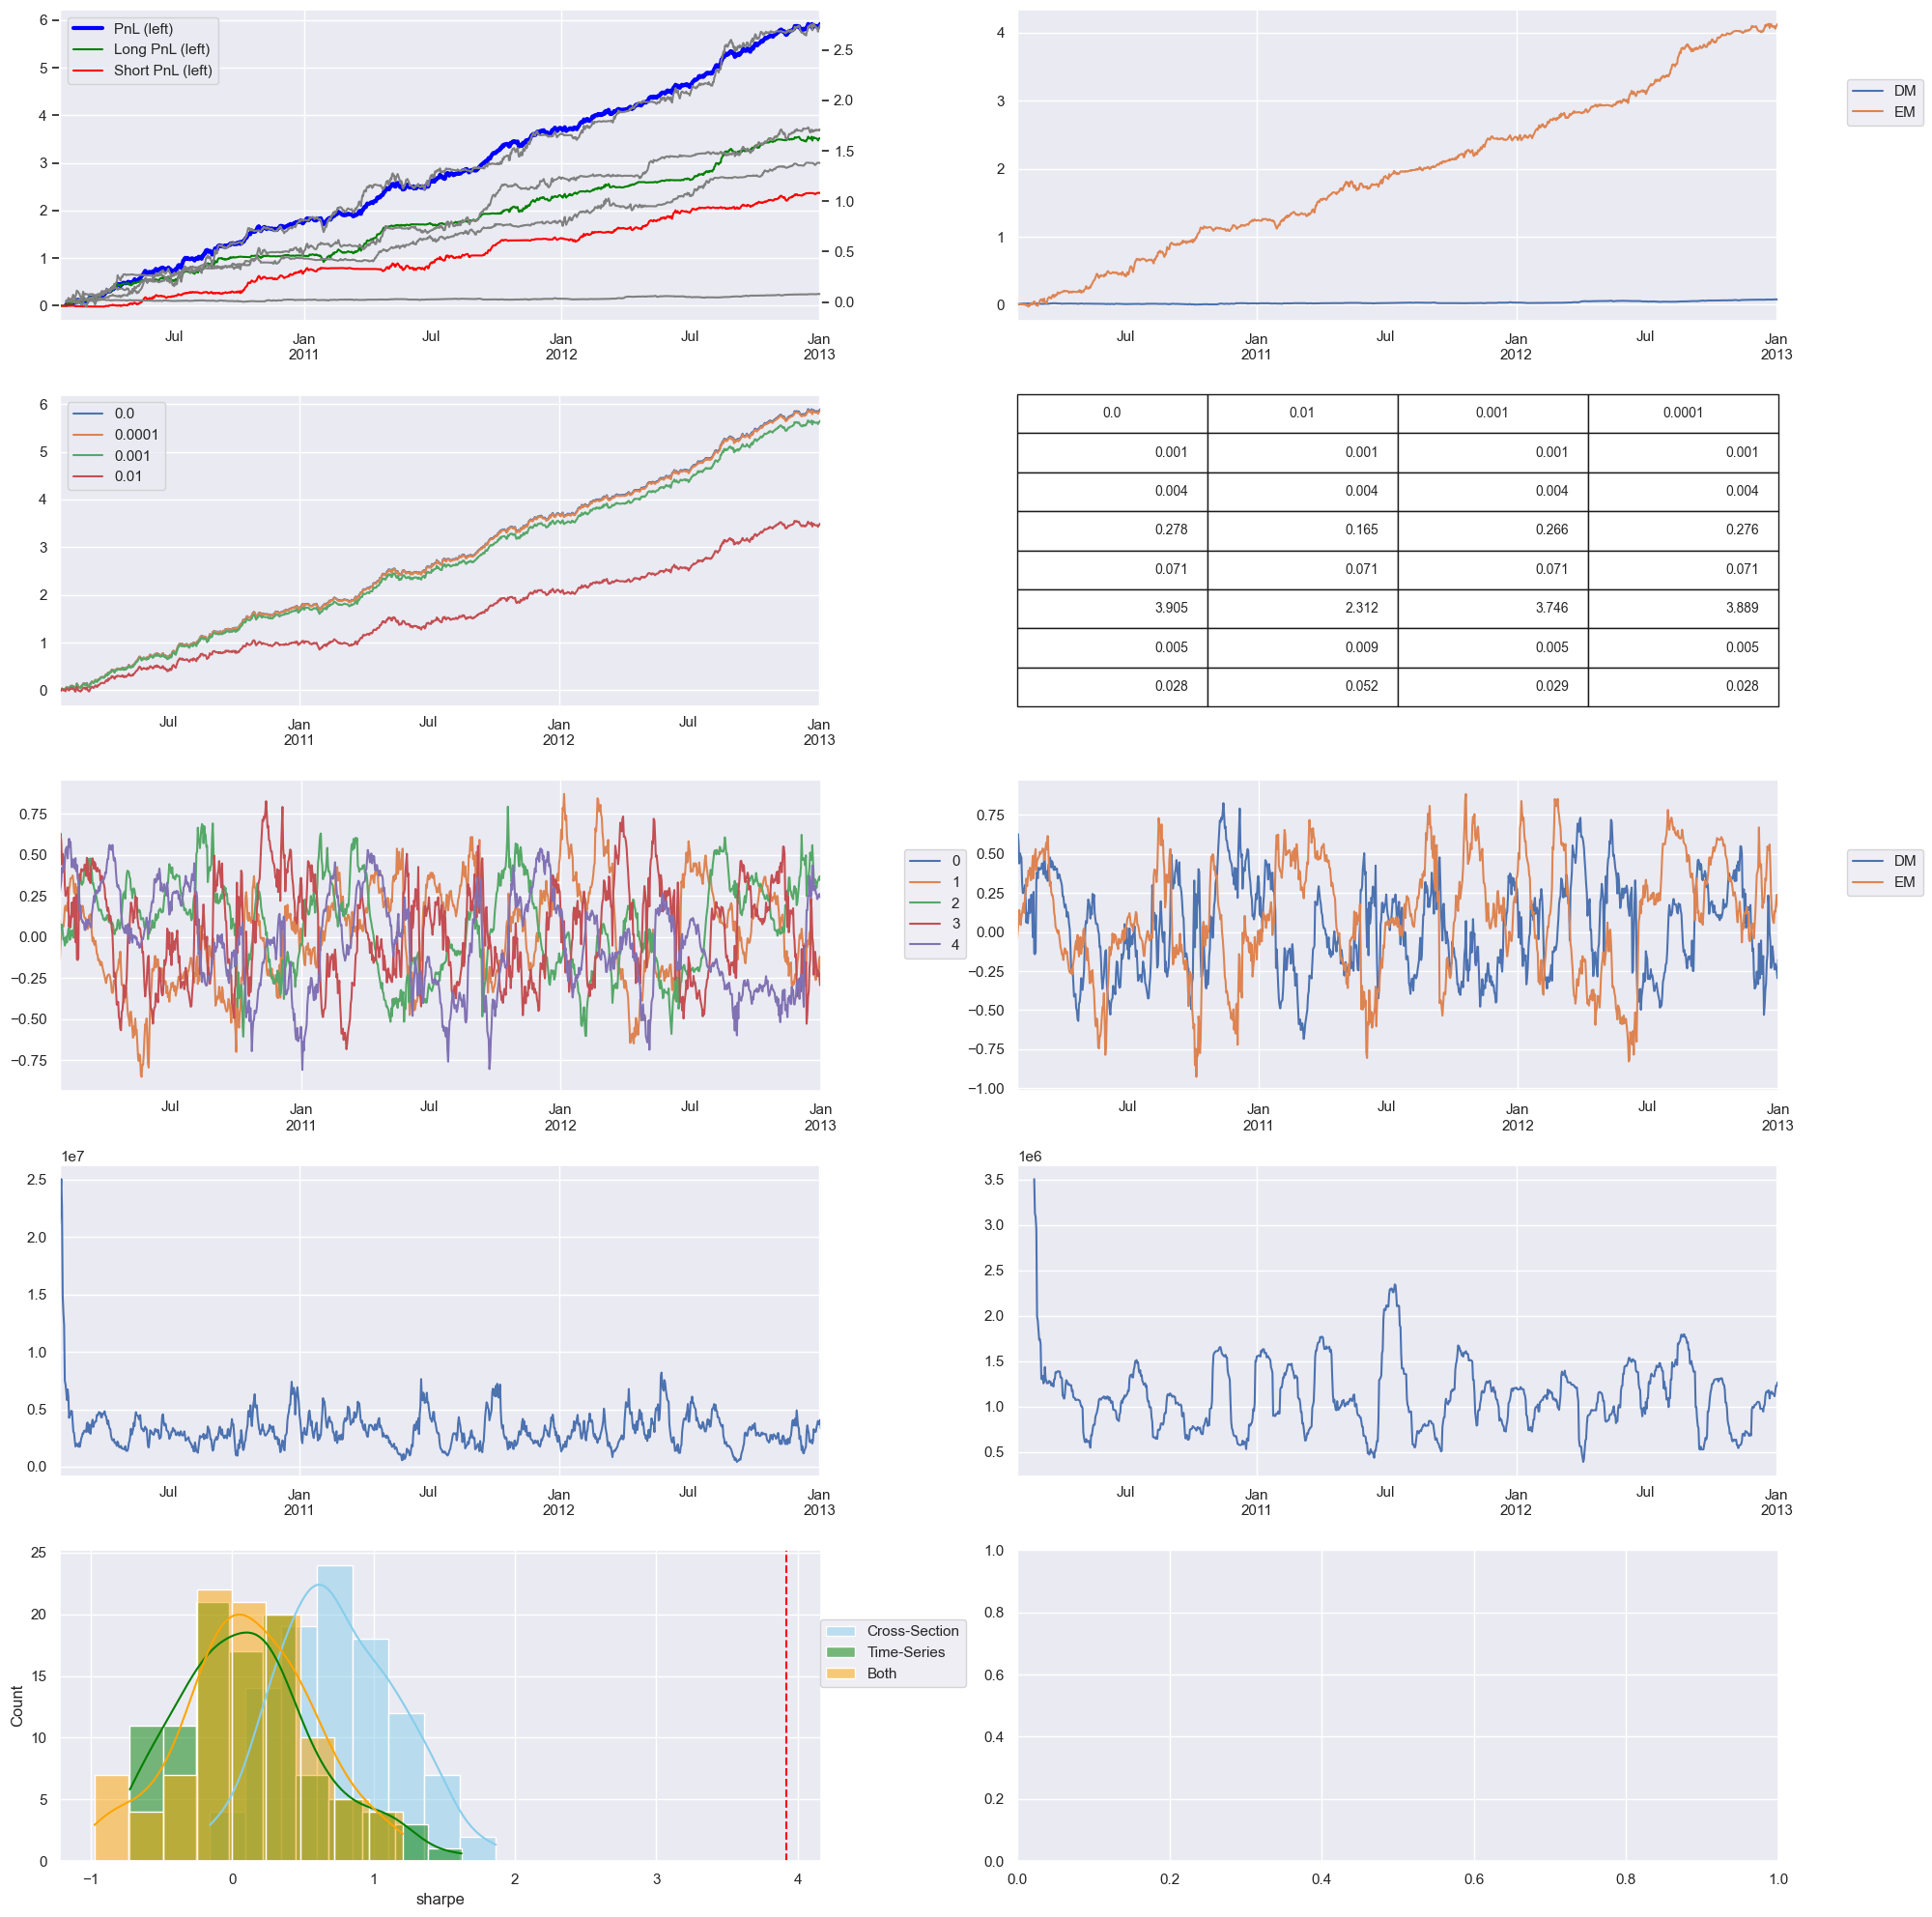

In [82]:

def plot(alpha):
    sns.set(style='darkgrid')
    fig, axes = plt.subplots(5, 2, figsize=(20, 20))
    alpha.df_pnl_capital.sum(axis=1).cumsum().plot(ax=axes[0][0], color='blue', linewidth=3)
    alpha.df_pnl_capital_long_short.groupby(level=0, axis=1).sum().cumsum().plot(ax=axes[0][0], color=['green', 'red'])
    axes[0][0].legend(['PnL (left)', 'Long PnL (left)', 'Short PnL (left)'])
    alpha.df_pnl_capital.cumsum().plot(ax=axes[0][0], color='gray', legend=False, secondary_y=True)
    alpha.df_pnl_by_group.groupby(level=0, axis=1).sum().cumsum().plot(ax=axes[0][1])
    axes[0][1].legend(bbox_to_anchor=[1.2, 0.8])
    
    alpha.df_pnl_with_tc.groupby(level=0, axis=1).sum().cumsum().plot(ax=axes[1][0])
    
    axes[1][1].axis('off')
    stats_with_tc_table = axes[1][1].table(cellText=alpha.df_stats_with_tc.round(3).T.values, colLabels=alpha.df_stats_with_tc.T.columns, loc='center')
    stats_with_tc_table.auto_set_font_size(False)
    stats_with_tc_table.set_fontsize(10)
    stats_with_tc_table.scale(1, 2) 
    
    alpha.df_weights.plot(ax=axes[2][0])    
    axes[2][0].legend(bbox_to_anchor=[1.2, 0.8])
    
    alpha.df_weights_by_group.groupby(level=0, axis=1).sum().plot(ax=axes[2][1])
    axes[2][1].legend(bbox_to_anchor=[1.2, 0.8])
    
    alpha.df_nominal.abs().sum(axis=1).plot(ax=axes[3][0])
    alpha.df_pnl_nominal.sum(axis=1).fillna(0).rolling(25, min_periods=25).std().mul(np.sqrt(252)).plot(ax=axes[3][1])
    
    
    stats = calc_stats(alpha.df_pnl_capital)
    
    sns.histplot(alpha.df_robustness_stats['Cross-Section']['sharpe'], color='skyblue', kde=True, label='Cross-Section', ax=axes[4][0])
    sns.histplot(alpha.df_robustness_stats['Time-Series']['sharpe'], color='green', label='Time-Series', kde=True, ax=axes[4][0])
    sns.histplot(alpha.df_robustness_stats['Both']['sharpe'], color='orange', label='Both', kde=True, ax=axes[4][0])

    axes[4][0].axvline(x=stats['sharpe'], color='red', linestyle='--')
    axes[4][0].legend(bbox_to_anchor=[1.2, 0.8])
    # axes[4][1].axvline(x=stats['sharpe'], color='red', linestyle='--')
    fig.tight_layout()
    
    

    plt.show()
    
plot(alpha1)